In [30]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
from pathlib import Path
from zipfile import ZipFile
import matplotlib.pyplot as plt
import pprint
import numpy as np
import seaborn as sns 

In [31]:
# Path to the CSV file
csv_file = './cleaned_merged_course_data.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file)


<AxesSubplot:xlabel='Fremmødte', ylabel='Eksamensgennemsnit'>

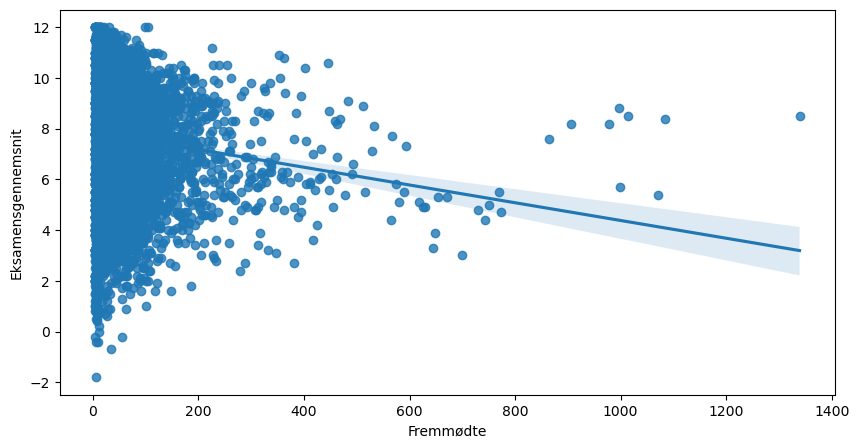

In [32]:
# Convert "Eksamensgennemsnit" to a numeric type
df['Eksamensgennemsnit'] = pd.to_numeric(df['Eksamensgennemsnit'].str.replace(',', '.'), errors='coerce')

# Ensure "Fremmødte" is numeric (if it isn't already)
df['Fremmødte'] = pd.to_numeric(df['Fremmødte'], errors='coerce')

fig, ax = plt.subplots(figsize=(10,5))
sns.regplot(y='Eksamensgennemsnit', x='Fremmødte', data=df)

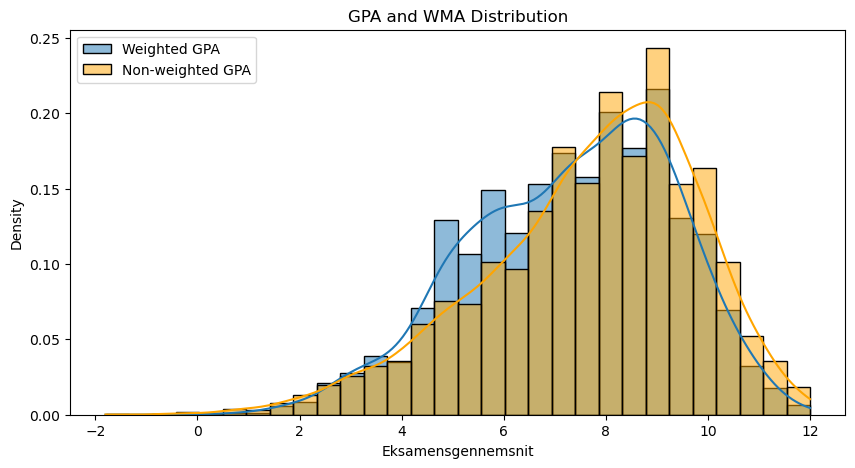

In [33]:
# Ensure 'Eksamensgennemsnit' is treated as a string first, then convert
df['Eksamensgennemsnit'] = df['Eksamensgennemsnit'].astype(str).str.replace(',', '.').astype(float)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the weighted GPA distribution
sns.histplot(data=df, x='Eksamensgennemsnit', weights='Fremmødte', kde=True, ax=ax, bins=30, stat='density', label='Weighted GPA')

# Plot the non-weighted GPA distribution
sns.histplot(data=df, x='Eksamensgennemsnit', kde=True, ax=ax, color='orange', bins=30, stat='density', label='Non-weighted GPA')

# Add legend and title
plt.legend()
ax.set_title("GPA and WMA Distribution")

# Show the plot
plt.show()